In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import cv2

print("open cv2 version: %s" % cv2.__version__)

open cv2 version: 3.3.1


In [2]:
# get the tracks
direc = r"../dataFolders/PaperPipelineOutput/FilteredTracks_v2/ManualCleanup/FinalTracks/FirstVisit/"
AllTracks = glob.glob(direc + "*.csv")

In [3]:
# use step 5 in moth learning to read out all the start stop frame numbers
9path_for_visit_frames = r"../../MothLearning/dataFolders/Output/Step5_FilesWith_TrueTrialAnd_ProboscisDetect_v2/"

In [4]:
pathForVideo = r"G:\My Drive\Tom-Tanvi\Moth Learning Project\AllVideosForAnalysis\CompliedDataForAnalysis"
ourVideoPath = glob.glob(pathForVideo + "\**\\*.mp4", recursive = True)

In [2]:
# create my own colormaps for tracks
from matplotlib.colors import ListedColormap

def createMyColorMap(N, hue):
    top_color = hue['top_color']
    bottom_color = hue['bottom_color']
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(bottom_color[0]/256, top_color[0]/256, N)
    vals[:, 1] = np.linspace(bottom_color[1]/256, top_color[1]/256, N)
    vals[:, 2] = np.linspace(bottom_color[2]/256, top_color[2]/256, N)
    newcmp = ListedColormap(vals)
    return(newcmp)

In [3]:
blue = {'top_color': [158, 202, 225], 'bottom_color': [8,81, 156]}
orange = {'top_color': [254, 237, 222], 'bottom_color': [166, 54, 3]}
red = {'top_color': [254, 229, 217], 'bottom_color': [165, 15, 21]}
multiHot = {'top_color': [240, 59, 32], 'bottom_color': [254, 217, 118]}
multiPink = {'top_color': [201, 148, 199], 'bottom_color': [152, 0, 67]}

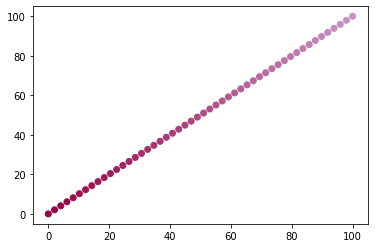

In [154]:
# test hue
N = 100
cx = np.linspace(0,N)
plt.scatter(cx, cx, c = cx, cmap = createMyColorMap(N=100,hue=multiPink))

In [38]:
mothID = 'c-3_m10'

In [39]:
SpecificVideoPath = [f for f in ourVideoPath if mothID in f][0]

# get vid info
cap = cv2.VideoCapture(SpecificVideoPath)

length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)
print(length, width, height, fps)

183794 648 488 30.0


In [44]:
path_frame_Reference = glob.glob(path_for_visit_frames + mothID + '*RawDataForExplorationTime.csv')
Visit_info = pd.read_csv(path_frame_Reference[0])
Visit_info = Visit_info[['MothIN', 'MothOut','ProboscisDetect']]

visit_num = 0
start = int(Visit_info.loc[visit_num, 'MothIN'])
stop = int(Visit_info.loc[visit_num, 'ProboscisDetect'])
if np.isnan(stop):
    stop = int(Visit_info.loc[visit_num, 'MothOut'])
success = int(Visit_info.loc[visit_num, 'ProboscisDetect'])
print(start, stop, success)

20255 21343 21343


In [122]:
# get probsocis track for that mothID
specificTrack = [f for f in AllTracks if mothID in f][0]
track = pd.read_csv(specificTrack)
x = track.x.values
y = track.y.values

In [42]:
# get tracks for moth for that mothID
mothTrackPath = r"../../MothLearning/dataFolders/Output/Step1_MotionDetection/"
mothTracks = glob.glob(mothTrackPath + "*.csv")
specificMothTracks = [f for f in mothTracks if mothID in f][0]

extra_frames = 0
mothTrack = pd.read_csv(specificMothTracks)
moth_x = mothTrack.Centroid_hull_x.values[start-extra_frames:stop+extra_frames]
moth_y = mothTrack.Centroid_hull_y.values[start-extra_frames:stop+extra_frames]

In [43]:
print(len(moth_x), len(moth_y))

1088 1088


In [45]:
from scipy import signal
def smooth(Pixels):
    win_gauss = signal.gaussian(10,3)
    smooth_Pixels = signal.convolve(Pixels, win_gauss, mode='same', method = 'direct') / win_gauss.sum()
    return(smooth_Pixels)

In [46]:
filt_moth_x = smooth(moth_x)
filt_moth_y = smooth(moth_y)

In [48]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

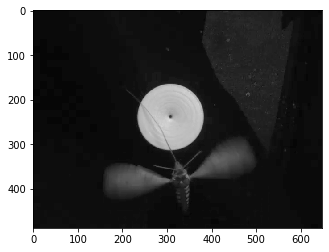

In [188]:
framestrt = 650
ff = start + framestrt
cap.set(1,ff)
ret, frame = cap.read()
adjusted = adjust_gamma(frame, gamma=1.5)

plt.imshow(adjusted)

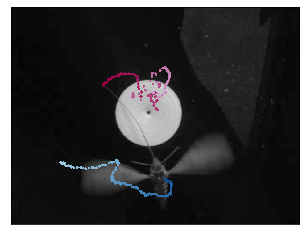

In [191]:
# plot traces as two fading colormaps
from matplotlib import cm
output = adjusted.copy()

lagPoints = 100

cmap_proboscis = createMyColorMap(N=lagPoints, hue=multiPink)
cmap_moth = createMyColorMap(N=lagPoints, hue=blue_hue)

for idx, jj in enumerate(range(lagPoints)):
    # add the proboscis trajectory
    cv2.circle(output, (int(x[np.max([framestrt-jj, 0])]), 
                         int(y[np.max([framestrt-jj, 0])])), 
               3, np.array(cmap_proboscis(idx/lagPoints)[:3])*256, -1)
    
    cv2.circle(output, (int(filt_moth_x[np.max([framestrt-jj, 0])]), 
                         int(filt_moth_y[np.max([framestrt-jj, 0])])), 
               3, np.array(cmap_moth(idx/lagPoints)[:3])*256, -1)

plt.imshow(output)
plt.xticks([])
plt.yticks([])
plt.savefig('../dataFolders/PaperPipelineOutput/Figures/v2/Paper/VideoFrame.pdf')

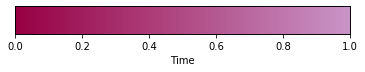

In [8]:
# create and save colorbars

import matplotlib as mpl

lagPoints = 100
cmap_proboscis = createMyColorMap(N=lagPoints, hue=multiPink)
cmap_moth = createMyColorMap(N=lagPoints, hue=blue)

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = cmap_moth
# norm = mpl.colors.Normalize(vmin=(framestrt - lagPoints)/100, vmax= framestrt/100)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                 norm=norm,
                                orientation='horizontal')
cb1.set_label('Time')
# fig.show()
plt.savefig('../dataFolders/PaperPipelineOutput/Figures/v2/Paper/colorbar_moth-v1.pdf')

cmap = cmap_proboscis
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                norm=norm,
                               orientation='horizontal')
cb2.set_label('Time')
plt.savefig('../dataFolders/PaperPipelineOutput/Figures/v2/Paper/colorbar_prooscis-v1.pdf')



In [108]:
# plot traces as fading points

overlay = frame.copy()
output = frame.copy()
frameNum = start + framestrt

# add circle, centered at closest integer value
lagPoints = 300
tempAlpha = np.sqrt(np.linspace(0.1, 0.5, lagPoints))
tempAlpha /= max(tempAlpha)/0.2
alphaVals = np.flip(tempAlpha, axis = 0)
# alphaVals = np.ones(shape=alphaVals.shape)

# cv2.circle(image, center_coordinates, radius, color, thickness)
for jj in range(lagPoints):
#     overlay = frame.copy()
    # add the proboscis trajectory
    cv2.circle(overlay, (int(x[np.max([framestrt-jj, 0])]), 
                         int(y[np.max([framestrt-jj, 0])])), 
               3, (200, 0, 50), -1)
    
    # add the moth trajectory
    cv2.circle(overlay, (int(filt_moth_x[np.max([framestrt-jj, 0])]), 
                         int(filt_moth_y[np.max([framestrt-jj, 0])])), 
               3, (64, 224, 208), -1)
    
    cv2.addWeighted(overlay, alphaVals[jj], output, 1 - alphaVals[jj],0, output)
    
#     plt.imshow(overlay)

plt.imshow(output)
plt.xticks([])
plt.yticks([])
plt.savefig('../dataFolders/PaperPipelineOutput/Figures/v2/Paper/VideoFrame.pdf')

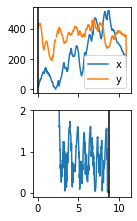

In [205]:
tracks = pd.DataFrame([filt_moth_x, filt_moth_y]).T
tracks.columns = ['moth_x', 'moth_y']
tracks.loc[extra_frames:,'proboscis_rpos'] = track.r

f, ax = plt.subplots(2,1, figsize = (3.5/2, 3.5), sharex = True)
ax = ax.ravel()

tt = np.arange(0, len(tracks['moth_x']))
ax[0].plot(tt/100, tracks.moth_x, label = 'x')
ax[0].plot(tt/100, tracks.moth_y, label = 'y')
ax[0].axvline(extra_frames/100, color = 'k')
ax[0].legend()

ax[1].plot(tt/100, tracks.proboscis_rpos)
ax[1].set_ylim([-0.1, 2])

probdetect = np.max(np.where(tracks.proboscis_rpos.notnull()))
ax[1].axvline(probdetect/100, color = 'k')
plt.savefig('../dataFolders/PaperPipelineOutput/Figures/v2/Paper/MothInOutAndProboscis.pdf')